# 1. `Network`: the base object of scikit-rf
In this first part of this short course, we give an overview of the microwave network analysis 
features of scikit-rf. For the rest of the short course, it is  assumed that scikit-rf (**skrf**) has been imported as `rf`:


In [1]:
import skrf as rf

# Creating Networks

<img src="figures/Nport_network.png" align="right">

**skrf** provides a Python object for a N-port microwave `Network`. A `Network` can be created in a number of ways:
 - from a Touchstone file (.sNP files)
 - from S-parameters
 - from Z-parameters
 - from other RF parameters (Y, ABCD, T, etc.) 
 
Some examples for each situation are given after.

## Creating Network from Touchstone file
[Touchstone file](https://en.wikipedia.org/wiki/Touchstone_file) (`.sNp` files, with `N` being the number of ports) is a _de facto_ standard to export N-port network parameter data and noise data of linear active devices, passive filters, passive devices, or interconnect networks. Creating a Network from a Touchstone file is simple:

In [2]:
ring_slot = rf.Network('data/ring slot.s2p')

Note that some softwares, such as ANSYS HFSS, add additional information to the Touchstone standard, such as comments, simulation parameters, Port Impedance or Gamma (wavenumber). These data are also imported if detected. 

	
A short description of the network will be printed out if entered onto the command line
	

In [3]:
ring_slot  # or: print(ring_slot)

2-Port Network: 'ring slot',  75.0-110.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

### Diving into the content of the `Network` object 

The `Network` object stores the scattering parameters of a the Network, but also many other informations:
- the frequency points 
- the characteristic impedances of the ports (which can be frequency dependent)

The S-parameter of a N-port network is stored in a `Network` as a Numpy array of shape `(nb_f, N, N)`, where `nb_f` is the number of frequency points and `N` the number of ports of the network. 

The S-parameter array is accessible with the `.s` parameter of the Network. For instance, our previous example is a 2-port with 201 frequency points, so the S-parameters array is of shape (201,2,2):

In [5]:
ring_slot.s.shape

(201, 2, 2)

### Creating Network from s-parameters
Networks can also be created by directly by passing the values for the `frequency` points and tehe s-parameters (and optionally the port impedance `z0`).

In [4]:
import numpy as np 
# dummy 2-port network from Frequency and s-parameters
freq = rf.Frequency(start=1, stop=10, npoints=101, unit='ghz')

s = np.random.rand(101, 2, 2) + 1j*np.random.rand(101, 2, 2)  # random complex numbers 
# if not passed, will assume z0=50. name is optional but it's a good practice.
ntwk = rf.Network(frequency=freq, s=s, name='random values 2-port') 
print(ntwk)

2-Port Network: 'random values 2-port',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]


# Exercice: creating a Network from S-parameters
Often, s-parameters are stored in separate arrays, say Numpy array `S11`, `S21`, `S12` and `S22`. 

In [5]:
# let's assume we have separate arrays for the frequency and s-parameters
f = np.array([1, 2, 3, 4]) # in GHz
S11 = np.random.rand(4)
S12 = np.random.rand(4)
S21 = np.random.rand(4)
S22 = np.random.rand(4)

In such case, one needs to forge the `frequency` and the `s` array of expected shape (nbf,2,2):

In [6]:
freq2 = rf.Frequency.from_f(f, unit='GHz')

In [7]:
# forging S-matrix as shape (nb_f, 2, 2)
s = np.zeros((len(f), 2, 2), dtype=complex)
s[:,0,0] = S11
s[:,0,1] = S12
s[:,1,0] = S21
s[:,1,1] = S22

In [8]:
# constructing Network object
ntw = rf.Network(frequency=freq2, s=s)
print(ntw)

2-Port Network: '',  1.0-4.0 GHz, 4 pts, z0=[50.+0.j 50.+0.j]


If necessary, the characteristic impedance can be passed as a scalar (same for all frequencies), as a list or an array:

In [9]:
ntw2 = rf.Network(frequency=freq, s=s, z0=25, name='same z0 for all ports')
print(ntw2)

2-Port Network: 'same z0 for all ports',  1.0-10.0 GHz, 101 pts, z0=[25.+0.j 25.+0.j]


In [16]:
ntw3 = rf.Network(frequency=freq, s=s, z0=[20, 30], name='different z0 for each port')
print(ntw3)

2-Port Network: 'different z0 for each port',  1.0-10.0 GHz, 101 pts, z0=[20.+0.j 30.+0.j]


In [10]:
ntw4 = rf.Network(frequency=freq, s=s, z0=np.random.rand(101,2), 
                  name='different z0 for each frequencies and ports')
print(ntw4)

2-Port Network: 'different z0 for each frequencies and ports',  1.0-10.0 GHz, 101 pts, z0=[0.80807483+0.j 0.58138651+0.j]


### Creating a Network from z-parameters 
As networks are also defined from their Z-parameters, there is `from_z()` method of the Network:

In [19]:
# 1-port network example
z = 10j
Z = np.full((len(freq), 1, 1), z)  # replicate z for all frequencies

ntw = rf.Network()
ntw = ntw.from_z(Z)
ntw.frequency = freq
print(ntw)

1-Port Network: '',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j]


### From other network parameters (Z, Y, ABCD, T)
It is also possible to generate Networks from other kind of RF parameters, using the conversion functions: `z2s`, `y2s`, `a2s`, `t2s`, `h2s`.

For example, the [ABCD parameters](https://en.wikipedia.org/wiki/Two-port_network#ABCD-parameters) of a serie-impedance is:
$$
\left[
\begin{array}{cc}
1 & Z \\
0 & 1
\end{array}
\right]
$$

In [11]:
z = 20
abcd = np.array([[1, z],
                 [0, 1]])

s = rf.a2s(np.tile(abcd, (len(freq),1,1))) # (2,2) -> (N,2,2)
ntw = rf.Network(frequency=freq, s=s)
print(ntw)

2-Port Network: '',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]


## Gettint the Basic Properties of a Network
	
The basic attributes of a microwave Network are provided by the following properties :

* `Network.s` : Scattering Parameter matrix. 
* `Network.z0`  : Port Characteristic Impedance matrix.
* `Network.frequency`  : Frequency Object. 



The `Network` object has numerous other properties and methods. If you are using IPython/Jupyter, then these properties and methods can be 'tabbed' out on the command line:

In [12]:
ring_slot # press .<TAB>

2-Port Network: 'ring slot',  75.0-110.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


All of the network parameters are represented internally as complex `numpy.ndarray`. The s-parameters are of shape (nfreq, nport, nport)

In [25]:
ring_slot.s.shape

(201, 2, 2)

## Projections
Network parameters, such as S-parameters, are complex numbers. However, it is more convenient to represent these network parameters using some mathematical projections, such as the magnitude in dB or the phase in degree.

Several mathematical projections of the network parameters are available for each network parameters. For example, if you want the magnitude in dB of the S-parameters:

In [13]:
ring_slot.s_db

array([[[ -3.34082483,  -2.91699627],
        [ -2.91699627,  -3.37080014]],

       [[ -3.4222167 ,  -2.84683359],
        [ -2.84683359,  -3.4532234 ]],

       [[ -3.50613007,  -2.77698192],
        [ -2.77698192,  -3.53821967]],

       [[ -3.59265913,  -2.70746271],
        [ -2.70746271,  -3.62588667]],

       [[ -3.68190224,  -2.63829807],
        [ -2.63829807,  -3.71632656]],

       [[ -3.77396221,  -2.56951074],
        [ -2.56951074,  -3.80964628]],

       [[ -3.86894646,  -2.50112414],
        [ -2.50112414,  -3.90595777]],

       [[ -3.96696735,  -2.43316234],
        [ -2.43316234,  -4.00537829]],

       [[ -4.06814247,  -2.36565007],
        [ -2.36565007,  -4.10803077]],

       [[ -4.17259488,  -2.29861268],
        [ -2.29861268,  -4.21404416]],

       [[ -4.28045355,  -2.23207619],
        [ -2.23207619,  -4.32355381]],

       [[ -4.39185361,  -2.16606723],
        [ -2.16606723,  -4.43670189]],

       [[ -4.50693682,  -2.10061306],
        [ -2.10061306,  -4

Or the phase in degrees:

In [27]:
ring_slot.s_deg

array([[[ 137.73162735,   30.87488554],
        [  30.87488554,  107.11053803]],

       [[ 137.3282022 ,   30.34598329],
        [  30.34598329,  106.49583731]],

       [[ 136.92136778,   29.81041539],
        [  29.81041539,  105.8725517 ]],

       [[ 136.51123044,   29.26812641],
        [  29.26812641,  105.24052962]],

       [[ 136.09791018,   28.71906373],
        [  28.71906373,  104.5996157 ]],

       [[ 135.68154183,   28.16317769],
        [  28.16317769,  103.94965042]],

       [[ 135.26227634,   27.60042191],
        [  27.60042191,  103.29046974]],

       [[ 134.8402821 ,   27.03075347],
        [  27.03075347,  102.62190465]],

       [[ 134.41574651,   26.4541332 ],
        [  26.4541332 ,  101.94378063]],

       [[ 133.98887758,   25.87052595],
        [  25.87052595,  101.25591704]],

       [[ 133.55990579,   25.2799008 ],
        [  25.2799008 ,  100.55812649]],

       [[ 133.12908603,   24.6822314 ],
        [  24.6822314 ,   99.85021395]],

       [[ 132.69

Several other projections are available, please refer to the documentation for the complete list.

# Slicing

You can slice the network parameters attribute, such as `Network.s`, any way you want:

In [28]:
ring_slot.s[:11,1,0]  # get first 10 values of S21

array([0.6134571 +0.36678139j, 0.6218194 +0.36403169j,
       0.63024301+0.36109574j, 0.63872415+0.3579682j ,
       0.64725874+0.35464377j, 0.65584238+0.35111711j,
       0.66447037+0.34738295j, 0.6731377 +0.34343602j,
       0.68183901+0.33927115j, 0.69056862+0.33488321j,
       0.6993205 +0.3302672j ])

Slicing by frequency can also be done directly on Network objects like so 

In [14]:
ring_slot[0:10] #  Network for the first 10 frequency points

2-Port Network: 'ring slot_subset',  75.0-76.575 GHz, 10 pts, z0=[50.+0.j 50.+0.j]

or  with a human friendly string,

In [30]:
ring_slot['80-90ghz']

2-Port Network: 'ring slot',  80.075-90.05 GHz, 58 pts, z0=[50.+0.j 50.+0.j]

Notice that slicing directly on a Network **returns a Network**:

A nice way to express slicing in both dimensions is 

In [31]:
ring_slot.s11['80-90ghz'] 

1-Port Network: 'ring slot',  80.075-90.05 GHz, 58 pts, z0=[50.+0.j]

## Other Parameters	

This tutorial focuses on s-parameters, but other network representations are available as well. Impedance and Admittance Parameters can be accessed through the parameters `Network.z` and `Network.y`, respectively. Scalar components of complex parameters, such as  `Network.z_re`, `Network.z_im` and plotting methods are available as well.

Other parameters are only available for 2-port networks, such as wave cascading parameters (`Network.t`), and  ABCD-parameters (`Network.a`)

In [15]:
ring_slot.z[:3,...]

array([[[0.88442687+28.15350224j, 0.94703504+30.46757222j],
        [0.94703504+30.46757222j, 1.0434417 +43.45766805j]],

       [[0.91624901+28.72415928j, 0.98188607+31.09594438j],
        [0.98188607+31.09594438j, 1.08168411+44.17642274j]],

       [[0.94991736+29.31694632j, 1.01876516+31.74874257j],
        [1.01876516+31.74874257j, 1.12215451+44.92215712j]]])

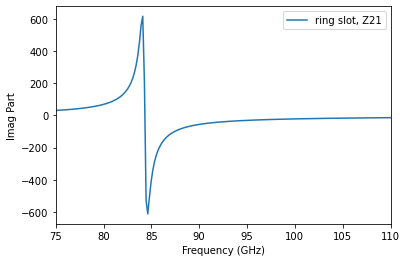

In [16]:
ring_slot.plot_z_im(m=1,n=0)  

# Plotting 

Amongst other things, the methods of the Network class provide convenient ways to plot components of the network parameters, for example:

* `Network.plot_s_db` : plot magnitude of s-parameters in log scale
* `Network.plot_s_deg` : plot phase of s-parameters in degrees
* `Network.plot_s_smith` : plot complex s-parameters on Smith Chart
* ... many other are available

To plot all the four S-parameters in dB:

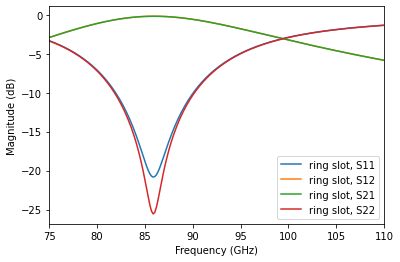

In [34]:
ring_slot.plot_s_db()

	
To plot all four s-parameters of the `ring_slot` on the Smith Chart.

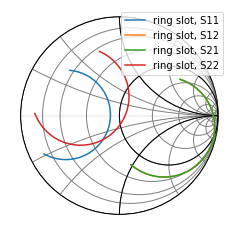

In [35]:
ring_slot.plot_s_smith()

Combining this with the slicing features, 

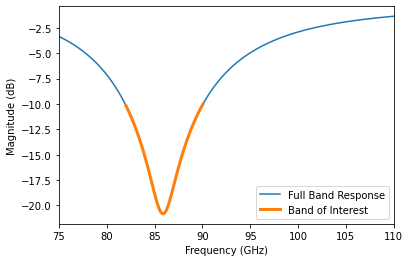

In [36]:
ring_slot.s11.plot_s_db(label='Full Band Response')
ring_slot.s11['82-90ghz'].plot_s_db(lw=3, label='Band of Interest')

# Arithmetic Operations 
Element-wise mathematical operations on the scattering parameter matrices are accessible through overloaded operators: `+`,`-`,`*`,`/`.

To illustrate their usage, load a couple of Networks stored in the `data` module of the package:

In [17]:
from skrf.data import wr2p2_short as short 
from skrf.data import wr2p2_delayshort as delayshort 

In [18]:
short - delayshort

1-Port Network: 'wr2p2,short',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j]

In [40]:
short + delayshort

1-Port Network: 'wr2p2,short',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j]

In [41]:
short * delayshort

1-Port Network: 'wr2p2,short',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j]

In [42]:
short / delayshort

1-Port Network: 'wr2p2,short',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j]

All of these operations return Network types.

For example, to plot the complex difference  between  `short` and `delay_short`:

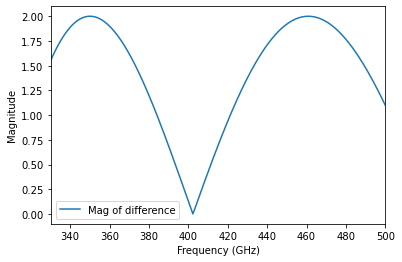

In [44]:
difference = (short - delayshort)
difference.plot_s_mag(label='Mag of difference')

Another common application is calculating the phase difference using the division operator,

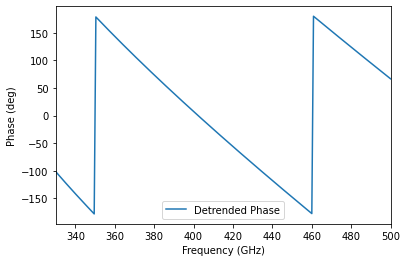

In [46]:
(delayshort/short).plot_s_deg(label='Detrended Phase')

Linear operators can also be used with scalars or an `numpy.ndarray` that is the same length as the Network:

In [47]:
hopen = short * (-1)
hopen.s[:3,...]

array([[[1.-0.j]],

       [[1.-0.j]],

       [[1.-0.j]]])

In [49]:
rando =  hopen * np.random.rand(len(hopen))
rando.s[:3,...]

array([[[0.44880433+0.j]],

       [[0.70786409+0.j]],

       [[0.57075618+0.j]]])

**warning** : Note that if you multiply a Network by an `numpy.ndarray`  be sure to place the array on the right side.

## Comparison of Network
Comparison operators also work with networks:

In [50]:
short == delayshort

False

In [ ]:
short != delayshort

# Cascading and De-embedding
Cascading and de-embeding 2-port Networks can also be done through operators. The `cascade` function can be called through the Python power operator, `**`. To calculate a new network which is the cascaded connection of the two individual Networks `line` and `short`: 

In [19]:
short = rf.data.wr2p2_short
line = rf.data.wr2p2_line
delayshort = line ** short

<img src="figures/cascading_delayshort.png"/>

De-embedding  can be accomplished by cascading the *inverse* of a network. The inverse of a network is accessed through the property `Network.inv`. To de-embed the `short` from `delay_short`,

In [20]:
short_2 = line.inv ** delayshort

<img src="figures/deembedding_delayshort.png"/>

In [55]:
short_2 == short

True

The cascading operator also works for to 2N-port Networks, also known as *balanced Networks*. For example, assuming you want to cascade two 4-port Network `ntw1`, `ntw2`, you can use:

`resulting_ntw = ntw1 ** ntw2`

Note that the port scheme assumed by the `**` cascading operator with 2N-port networks is:
<img src="figures/cascade_2Nport_2Nport.png"/>

## Connecting Multi-ports 

**skrf** supports the connection of arbitrary ports of N-port networks. It accomplishes this using an algorithm called *sub-network growth*,  available through the function `connect()`. 

As an example, terminating one port of an ideal 3-way splitter can be done like so,

In [56]:
tee = rf.data.tee
tee

3-Port Network: 'tee',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]

To connect port `1` of the tee, to port `0` of the delay short,

In [57]:
terminated_tee = rf.connect(tee, 1, delayshort, 0)
terminated_tee

2-Port Network: 'tee',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

Note that this function takes into account port impedances. If two connected ports have different port impedances,  an appropriate impedance mismatch is inserted. 

For advanced connections between many arbitrary N-port Networks, the `Circuit` object is more relevant since it allows defining explicitly the connections between ports and Networks. We will see the `Circuit` class later in this short course.

	
# Interpolation and Concatenation

A common need is to change the number of frequency points of a [Network](../api/network.rst). To use the operators and cascading functions the networks involved must have matching frequencies, for instance. If two networks have different frequency information, then an error will be raised, 

In [59]:
from skrf.data import wr2p2_line1 as line1

line1

2-Port Network: 'wr2p2,line1',  330.0-500.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]

In [60]:
line1+line  # will fail

IndexError: Networks must have same frequency. See `Network.interpolate`

This problem can be solved by interpolating one of Networks along the frequency axis using `Network.resample`. 

In [62]:
line1.resample(201)
line1

2-Port Network: 'wr2p2,line1',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

And now we can do things

In [63]:
line1 + line

2-Port Network: 'wr2p2,line1',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

You can also interpolate from a `Frequency` object. For example, 

In [65]:
line.interpolate_from_f(line1.frequency)

2-Port Network: 'wr2p2,line',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

A related application is the need to combine Networks which cover different frequency ranges. Two  Networks can be concatenated (aka *stitched*) together using `stitch`, which  concatenates networks along their frequency axis. To combine a WR-2.2 Network with a WR-1.5 Network, 

In [68]:
from skrf.data import wr2p2_line, wr1p5_line
print(wr2p2_line)
print(wr1p5_line)

2-Port Network: 'wr2p2,line',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]
2-Port Network: 'wr1p5,line',  500.0-750.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


In [ ]:
big_line = rf.stitch(wr2p2_line, wr1p5_line)
big_line

# Reading and Writing 
**skrf** supports writing [touchstone file format](http://en.wikipedia.org/wiki/Touchstone_file). While reading is accomplished with the Network initializer as shown before, writing is accomplished the method  `Network.write_touchstone()`.

In [ ]:
ring_slot.write_touchstone('test.s2p')